In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# src files
from situation_testing.situation_testing import SituationTesting
# plot params
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=11)
plt.rc('legend', fontsize=11)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [6]:
# working directory
wd = os.path.dirname(os.getcwd())
# relevant folders
data_path = os.path.abspath(os.path.join(wd, 'data')) + '\\'
resu_path = os.path.abspath(os.path.join(wd, 'results')) + '\\'
figu_path = resu_path + 'figures' + '\\'

In [ ]:
# factual dataset
org_df    = pd.read_csv(data_path + 'LoanApplication_v2.csv', sep='|', )
# counterfactual dataset
org_cf_df = pd.read_csv(data_path + 'counterfactuals\\cf_LoanApplication_v2.csv', sep='|', )

## The impact of $|k|$, given $\tau$

In [ ]:
### data
test_df    = org_df.copy()
test_cf_df = org_cf_df.copy()

### parameters
alpha = 0.05
tau   = 0.0
k_l = 1
# k_u = 250
k_u = 500

### ST object
st = SituationTesting()
st.setup_baseline(test_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

### CST object
cst = SituationTesting()
cst.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

In [ ]:
temp_k = []

for k in range(k_l, k_u + 1):
    print(k)
    
    # --- ST
    st.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1},
           sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1}, 
           k=k, alpha=alpha, tau=tau)
    
    temp_test_disc_st = st.get_test_discrimination()
    
    # --- CST without
    cst.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1}, 
            sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
            include_centers=False, 
            k=k, alpha=alpha, tau=tau)
    
    temp_test_disc_wo = cst.get_test_discrimination()
    
    # --- CST with
    cst.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1}, 
            sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
            include_centers=True, 
            k=k, alpha=alpha, tau=tau)
    
    temp_test_disc_wi = cst.get_test_discrimination()
    
    # --- CF
    cf = cst.res_counterfactual_unfairness
    
    # --- results
    temp_k.append(
        {
        'k': k,
        # Num. of discrimination cases
        'ST_num': temp_test_disc_st[temp_test_disc_st['DiscEvi'] == 'Yes'].shape[0],
        'CSTwo_num': temp_test_disc_wo[temp_test_disc_wo['DiscEvi'] == 'Yes'].shape[0],
        'CSTwi_num': temp_test_disc_wi[temp_test_disc_wi['DiscEvi'] == 'Yes'].shape[0],
        'ST_num_sig': temp_test_disc_st[(temp_test_disc_st['DiscEvi'] == 'Yes') & (temp_test_disc_st['StatEvi'] == 'Yes')].shape[0],
        'CSTwo_num_sig': temp_test_disc_wo[(temp_test_disc_wo['DiscEvi'] == 'Yes') & (temp_test_disc_wo['StatEvi'] == 'Yes')].shape[0],
        'CSTwi_num_sig': temp_test_disc_wi[(temp_test_disc_wi['DiscEvi'] == 'Yes') & (temp_test_disc_wi['StatEvi'] == 'Yes')].shape[0],
        'CF_num': sum(cf == 1),
        'CF_num_sig': temp_test_disc_wi[temp_test_disc_wi['individual'].isin(cf[cf == 1].index.to_list()) & (temp_test_disc_wi['StatEvi'] == 'Yes')].shape[0],
        'CF_avgCI_l': temp_test_disc_wi['CI_2st'].apply(lambda x: x[0]).mean(),
        'CF_avgCI_u': temp_test_disc_wi['CI_2st'].apply(lambda x: x[-1]).mean(),
        # Avg. delta p
        'ST_diff': temp_test_disc_st[temp_test_disc_st['DiscEvi'] == 'Yes']['delta_p'].mean(),
        'CSTwo_diff': temp_test_disc_wo[temp_test_disc_wo['DiscEvi'] == 'Yes']['delta_p'].mean(),
        'CSTwi_diff': temp_test_disc_wi[temp_test_disc_wi['DiscEvi'] == 'Yes']['delta_p'].mean(),
        'ST_diff_sig': temp_test_disc_st[(temp_test_disc_st['DiscEvi'] == 'Yes') & (temp_test_disc_st['StatEvi'] == 'Yes')]['delta_p'].mean(),
        'CSTwo_diff_sig': temp_test_disc_wo[(temp_test_disc_wo['DiscEvi'] == 'Yes') & (temp_test_disc_wo['StatEvi'] == 'Yes')]['delta_p'].mean(),
        'CSTwi_diff_sig': temp_test_disc_wi[(temp_test_disc_wi['DiscEvi'] == 'Yes') & (temp_test_disc_wi['StatEvi'] == 'Yes')]['delta_p'].mean(),
        }
    )
    
    del temp_test_disc_wo, temp_test_disc_wi, temp_test_disc_st, cf
print('=== DONE ===')

k_results = pd.DataFrame(temp_k)
del temp_k

k_results.to_csv(resu_path + '\\res_LoanApplication_k_analysis.csv', sep='|', index=True)
k_results.head(5)
print('=== SAVED ===')

In [7]:
k_results = pd.read_csv(resu_path + '\\res_LoanApplication_k_analysis.csv', sep='|')

In [8]:
# these results go from 1 to 500
K_l = 1
k_u = 500
x_axis = list(range(50, k_u + 1, 50))
x_axis.append(1)
x_axis = sorted(x_axis)
x_axis

[1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

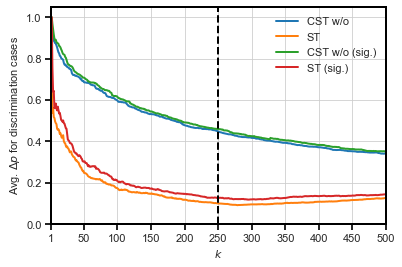

In [15]:
plt.plot(k_results['k'], k_results['CSTwo_diff'], label='CST w/o')
plt.plot(k_results['k'], k_results['ST_diff'], label='ST')
plt.plot(k_results['k'], k_results['CSTwo_diff_sig'], label='CST w/o (sig.)')
plt.plot(k_results['k'], k_results['ST_diff_sig'], label='ST (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0.0, 1.05)
plt.ylabel("Avg. $\Delta p$ for discrimination cases")
plt.axvline(x=250, linestyle='--', color='black') #, label='$k=250$')
plt.legend()
# plt.title('CST w/o vs ST')
plt.savefig(os.path.join(figu_path, 'CSTwoVsST_delta_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

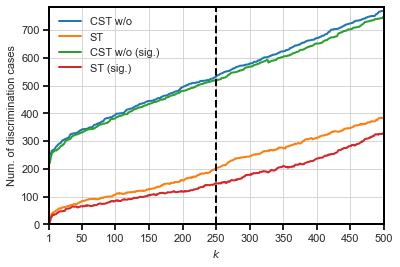

In [16]:
plt.plot(k_results['k'], k_results['CSTwo_num'], label='CST w/o')
plt.plot(k_results['k'], k_results['ST_num'], label='ST')
plt.plot(k_results['k'], k_results['CSTwo_num_sig'], label='CST w/o (sig.)')
plt.plot(k_results['k'], k_results['ST_num_sig'], label='ST (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0, k_results.iloc[-1].max() + 15)
# plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
plt.axvline(x=250, linestyle='--', color='black') #, label='$k=250$')
plt.ylabel("Num. of discrimination cases")
plt.legend()
# plt.title('CST w/o vs ST')
plt.savefig(os.path.join(figu_path, 'CSTwoVsST_nums_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

=== === === === ===

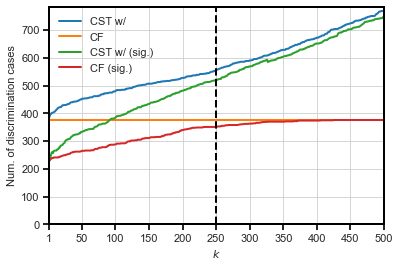

In [17]:
plt.plot(k_results['k'], k_results['CSTwi_num'], label='CST w/')
plt.plot(k_results['k'], k_results['CF_num'], label='CF')
plt.plot(k_results['k'], k_results['CSTwi_num_sig'], label='CST w/ (sig.)')
plt.plot(k_results['k'], k_results['CF_num_sig'], label='CF (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0, k_results.iloc[-1].max() + 15)
# plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
plt.ylabel("Num. of discrimination cases")
plt.axvline(x=250, linestyle='--', color='black') #, label='$k=250$')
plt.legend()
# plt.title('CST w/ vs CF')
plt.savefig(os.path.join(figu_path, 'CSTwiVsCF_nums_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# plt.plot(k_results['k'], k_results['CF_avgCI_l'], label='avg. lower CI', linestyle='--')
# plt.plot(k_results['k'], k_results['CF_avgCI_u'], label='avg. upper CI', linestyle='--')
# # plt.plot(k_results['k'], k_results['CF_d1_num'], label='CF')
# # plt.plot(k_results['k'], k_results['CF_d2_num'], label='CF (sig.)')
# plt.axhline(y=0.0, label='$\\tau$', color='g')
# plt.xlim(0, k_u+1)
# plt.xlabel("$k$")
# plt.ylim(-1, 1)
# # plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.ylabel("Uncertainty around CF")
# plt.legend()
# plt.title('CST w/ vs CF')
# plt.show()

=== === === === ===

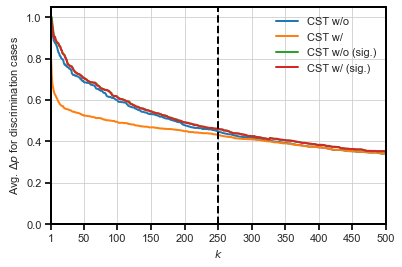

In [18]:
plt.plot(k_results['k'], k_results['CSTwo_diff'], label='CST w/o')
plt.plot(k_results['k'], k_results['CSTwi_diff'], label='CST w/')
plt.plot(k_results['k'], k_results['CSTwo_diff_sig'], label='CST w/o (sig.)')
plt.plot(k_results['k'], k_results['CSTwi_diff_sig'], label='CST w/ (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0.0, 1.05)
plt.ylabel("Avg. $\Delta p$ for discrimination cases")
plt.axvline(x=250, linestyle='--', color='black') #, label='$k=250$')
plt.legend()
# plt.title('CST w/o vs CST w/')
plt.savefig(os.path.join(figu_path, 'twoCST_delta_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

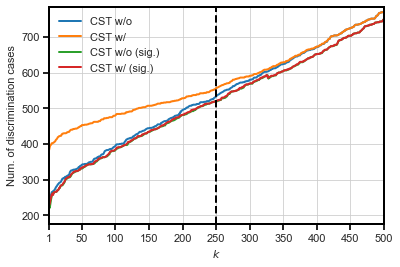

In [19]:
plt.plot(k_results['k'], k_results['CSTwo_num'], label='CST w/o')
plt.plot(k_results['k'], k_results['CSTwi_num'], label='CST w/')
plt.plot(k_results['k'], k_results['CSTwo_num_sig'], label='CST w/o (sig.)')
plt.plot(k_results['k'], k_results['CSTwi_num_sig'], label='CST w/ (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(175, k_results.iloc[-1].max() + 15)
# plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
plt.ylabel("Num. of discrimination cases")
plt.axvline(x=250, linestyle='--', color='black') #, label='$k=250$')
plt.legend()
# plt.title('CST w/o vs CST w/')
plt.savefig(os.path.join(figu_path, 'twoCST_nums_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

=== === === === ===

### EOF